<h1 align="center">CNN para classificação de imagens</h1>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Link de estudo:

* [Image Classification using Transfer Learning in PyTorch](https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/)

# Importando as nossas bibliotecas

In [24]:
import os

import numpy as np
import pandas as pd

import PIL.Image

import torch, torchvision
from torchvision import datasets, models, transforms
from torchvision.models import alexnet
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time

from matplotlib import pyplot as plt


# Re-dimensionamos nossas Imagens

Lembrar que para modelos mais robustos considere em aplicar `Data augmentation`, `Rotações da imagem`, `Espelhamento`, `Crop randómico`, etc.

In [25]:
# Aqui apenas vamos a re-dimensionar as nossas imagens: 100x100

image_size = 100
transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}

# Carregamos as nossas Imagens (Dataset de Treino - Validação - Teste)

A seguir carregamos as nossas Imagens. Temos as pastas de treino - validacao - teste.

In [26]:
# Carregar as imagens
# Determinar as pastas de treino, validação e teste

dataset = r'./data/'

pasta_treino = os.path.join(dataset, 'treino')
pasta_validacao = os.path.join(dataset, 'validacao')
pasta_teste = os.path.join(dataset, 'teste')

In [27]:
bs = 16 # Batch_size

# Determinando o número de classes
numero_de_classes = len(os.listdir(pasta_validacao))  # Temos três classes

In [28]:
numero_de_classes

3

In [29]:
# Carregar as imagens usando o datasets do torchvision

data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

# Total de dados de treino = 94 (todas as imagens, ou seja as classes)

In [30]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 94
     Root location: ./data/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 18
     Root location: ./data/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            )}

# Rótulo de nossas Imagens

In [31]:
# Mapear os índices com os nomes das classes (entregue e devolvido)
indice_para_classe = {v: k for k, v in data['treino'].class_to_idx.items()}
print(indice_para_classe)


{0: 'chocolate', 1: 'cocacola', 2: 'guarana'}


In [32]:
# Quantidade de imagens para serem utilizados para calcular erro médio e accuracy
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao


(94, 18)

In [33]:
# Cria os DataLoaders para treino e validação
data_loader_treino = DataLoader(data['treino'], batch_size=bs, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=bs, shuffle=True)

In [34]:
data_loader_treino

# Visualizamos nossas Imagens

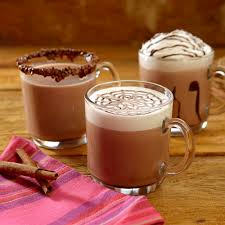

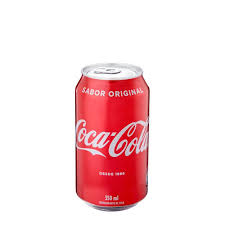

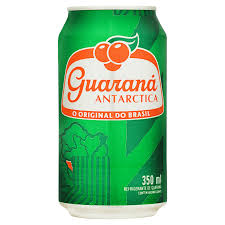

In [35]:
from IPython.display import Image 

# Mostrar algumas imagens
for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

# Carregamos nosso modelo pré-treinado

In [36]:
alexnet = models.alexnet(pretrained=True)
alexnet


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
for i, w in enumerate(alexnet.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 11, 11]) True
1 torch.Size([64]) True
2 torch.Size([192, 64, 5, 5]) True
3 torch.Size([192]) True
4 torch.Size([384, 192, 3, 3]) True
5 torch.Size([384]) True
6 torch.Size([256, 384, 3, 3]) True
7 torch.Size([256]) True
8 torch.Size([256, 256, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([4096, 9216]) True
11 torch.Size([4096]) True
12 torch.Size([4096, 4096]) True
13 torch.Size([4096]) True
14 torch.Size([1000, 4096]) True
15 torch.Size([1000]) True


In [38]:
# Congelamos os parametros da Rede Neural pré-treinada
for param in alexnet.parameters():
    param.requires_grad = False

In [39]:
# Mudar a última camada para alterar o número de classes
alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1)) 
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Nosso Otimizador

In [40]:
# Definição de algoritmo de otimização de gradiente descendente e função de erro
funcao_erro = nn.NLLLoss() # Negative Log Likelihood Loss
otimizador = optim.Adam(alexnet.parameters(), lr=0.001) # otimizador de passos para o SGD
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# Definimos a nossa função de Treinamento e Validação

In [41]:
from torch import device


def treinar_e_validar(modelo, metrica_erro, otimizador_sgd, epocas=25):
    '''
    Função para treinamento e validação
    Parâmetros
        :param modelo: modelo para treinar e validar
        :param metrica_erro: critério de erro para minização
        :param otimizador_sgd: otimizador para calcular os gradientes
        :param epocas: número de épocas (default=25)
  
    Retorna
        melhor_modelo: modelo treinado com a melhor acurácia na validação
        historico: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    # inicializando historico, a melhor acuracia de validação e o melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None

    # Cada época perpassa todas as imagens do treino e calcula erros de treino e validação
    # para aprendizado da rede neural
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Mudar o modelo para modo treino: vai atualizar os parametros da rede neural
        modelo.train()
        
        # Erro e acurácia de treino nessa época
        erro_treino = 0.0
        acuracia_treino = 0.0
        
        # Erro e acurácia de validação nessa época
        erro_validacao = 0.0
        acuracia_validacao = 0.0
        
        # Itera a cada lote de imagem. As entradas são os tensores do lote (batch)
        # e o label são as classificações de cada imagem do lote: 
        # chocolate, coca cola ou guarana (0, 1 e 2)
        for i, (entradas, labels) in enumerate(data_loader_treino):

            # joga pra GPU ou CPU, dependendo do seu hardware
            entradas = entradas.to(device)
            labels = labels.to(device)
            
            # Limpar os gradientes: zerar os gradientes
            otimizador_sgd.zero_grad()
            
            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            saidas = modelo(entradas)
            
            # Calcular erro das saidas que foram preditas no forward pass
            # comparando com as classificacoes reais (predito vs real)
            erro = metrica_erro(saidas, labels)
            
            # Realizar backpropagation do erro para treinar os coeficientes da rede
            erro.backward()
            
            # Atualizar os parâmetros do otimizador (no nosso caso, Adam Optimizer)
            otimizador_sgd.step()
            
            # Calcular o erro total para esse lote (batch) e soma o erro no treino
            erro_treino += erro.item() * entradas.size(0)
            
            # Cálculo da acurácia
            # Pra calcular a acurácia temos que buscar as classes preditas para cada imagem no lote
            
            # Cada tensor é uma imagem do lote com três posições: probabilidades de cada classe
            # torch.max vai retornar o valor da maior probabilidade, bem como a posição no tensor (tupla de saída)
            # A posição, portanto, vai indicar a classe com maior probabilidade (0,1 ou 2)
            # 1o busca o valor máximo de cada tensor de cada imagem, que vai dar 
            valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
            predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
            
            # Converter os acertos para float e calcular a acurácia média
            acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em train_acc
            acuracia_treino += acuracia.item() * entradas.size(0)
            
            print("Treino - Lote número {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(i, erro.item(), acuracia.item()))

            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        with torch.no_grad():

            # Mudando de treino para validação
            modelo.eval()

            # Iteração de validação
            for j, (entradas, labels) in enumerate(data_loader_validacao):
                entradas = entradas.to(device)
                labels = labels.to(device)

                # Forward pass de validação
                saidas = modelo(entradas)

                # Calcular erro de validação
                erro = metrica_erro(saidas, labels)

                # Calcular erro de validação e adicionar a valid_loss
                erro_validacao += erro.item() * entradas.size(0)

                # Calcular a acurácia de validação
                valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
                predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))

                # Converter os acertos para float e calcular a acurácia média
                acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))

                # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc
                acuracia_validacao += acuracia.item() * entradas.size(0)

                print("Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(j, erro.item(), acuracia.item()))
            
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acuracia_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acuracia_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias méidas
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo
            
    return melhor_modelo, historico

In [42]:
# Se você for rico e tiver uma RTX 3080 (que sonho!!)
# Mas se não for, sem problemas, sua CPU provavelmente vai dar conta do recado!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imprime se vai ser CPU ou alguma GPU
print(f'{device}\n')

# Define o número de épocas
numero_de_epocas = 40

# treina o modelo! Finalmente!!
modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas)

cpu



Época: 1/40
Treino - Lote número 000, Erro: 0.9087, Acurácia: 0.5625
Treino - Lote número 001, Erro: 0.5307, Acurácia: 0.8750
Treino - Lote número 002, Erro: 0.2248, Acurácia: 1.0000
Treino - Lote número 003, Erro: 0.0778, Acurácia: 1.0000
Treino - Lote número 004, Erro: 0.0808, Acurácia: 1.0000
Treino - Lote número 005, Erro: 0.0424, Acurácia: 1.0000
Validação - Lote número: 000, Erro: 0.0713, Acurácia: 1.0000
Validação - Lote número: 001, Erro: 0.0002, Acurácia: 1.0000
Época : 001, Treino: Erro: 0.3165, Acurácia: 90.4255%, 
		Validação : Erro : 0.0634, Acurácia: 100.0000%, Tempo: 0.6931s


Época: 2/40
Treino - Lote número 000, Erro: 0.0967, Acurácia: 1.0000
Treino - Lote número 001, Erro: 0.0223, Acurácia: 1.0000
Treino - Lote número 002, Erro: 0.0063, Acurácia: 1.0000
Treino - Lote número 003, Erro: 0.1597, Acurácia: 0.9375
Treino - Lote número 004, Erro: 0.0200, Acurácia: 1.0000
Treino - Lote número 005, Erro: 0.0055, Acurácia: 1.0000
Validação - Lote número: 000, Erro: 0.01

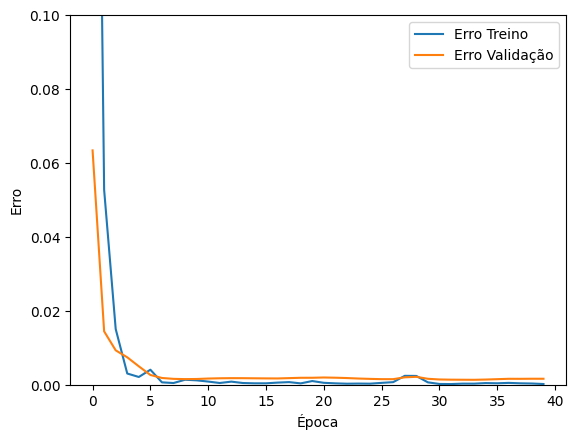

In [43]:
# Mostra o erro de treino e validação a cada época treinada

historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,0.1)
plt.show()

# Predição de nosso Modelo

In [45]:
def predicao(modelo, arquivo_imagem_teste):
    '''
    Função para realizar a predição do status do AR
    Parâmetros
        :param modelo: modelo para testar
        :param arquivo_imagem_teste: caminho para imagem de teste
    '''
    
    transformacao = transformacoes_de_imagens['teste']

    imagem_teste = PIL.Image.open(arquivo_imagem_teste)
    plt.imshow(imagem_teste)
    
    tensor_imagem_teste = transformacao(imagem_teste)

    # Testa se voce é rico, ops, se tem uma placa NVIDIA :)
    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
    else:
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
    
    dict_predicoes = dict()
    
    # Não precisa atualizar os coeficientes do modelo
    with torch.no_grad():
        modelo.eval()
        # Modelo retorna as probabilidades em log (log softmax)
        saida = modelo(tensor_imagem_teste)
        
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        ps = torch.exp(saida)
        
        # topk retorna o os k maiores valores do tensor
        # o tensor de probabilidades vai trazer na 1a posição a classe com maior
        # probabilidade de predição
        topk, topclass = ps.topk(numero_de_classes, dim=1)
        for i in range(numero_de_classes):
            dict_predicoes[indice_para_classe[topclass.cpu().numpy()[0][i]]] = topk.cpu().numpy()[0][i]
    
    return dict_predicoes

{'chocolate': 0.9999999, 'cocacola': 1.2983168e-07, 'guarana': 3.264967e-09}

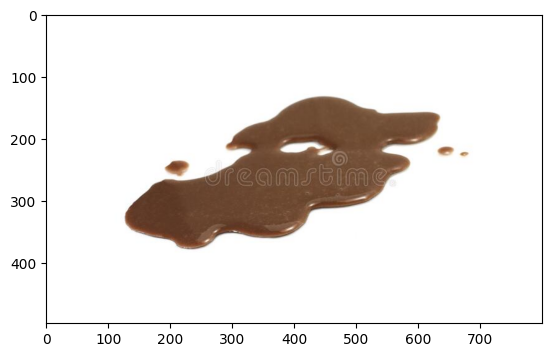

In [69]:
classe = 'chocolate' # Façõ a predição com esta classe!
pasta = f'./data/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[1])

predicao(modelo_treinado, imagem)

In [23]:
torch.save(modelo_treinado, './modelos/melhor_modelo.pt')